# Anotação aos professores e avaliadores:
Para o funcionamento adequado do código, é necessário que a variável `AZURE_ACCOUNT_KEY` na célula abaixo seja preenchida com a **secret key** enviada junto ao PDF do projeto, ou que essa chave seja configurada como variável de ambiente `export AZURE_ACCOUNT_KEY="secret_key_aqui"`.
Essa medida foi adotada por questões de segurança, uma vez que o repositório é público.
Agradecemos desde já pela compreensão e colaboração.

In [ ]:
# Coloque aqui sua chave de conta do Azure
AZURE_ACCOUNT_KEY = ""  # <-- INSIRA AQUI SUA CHAVE DO AZURE Entre as aspas duplas

## Imports:

In [5]:
import os
from io import BytesIO, StringIO

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from azure.storage.blob import BlobServiceClient
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

## Configuration:

In [ ]:
AZURE_ACCOUNT_KEY = os.environ.get("AZURE_ACCOUNT_KEY", AZURE_ACCOUNT_KEY)
if not AZURE_ACCOUNT_KEY:
    raise ValueError("A chave da conta do Azure não foi definida. Por favor, defina a variável AZURE_ACCOUNT_KEY.")

AZURE_CONNECTION_STRING = f"DefaultEndpointsProtocol=https;AccountName=totsvisiodb;AccountKey={AZURE_ACCOUNT_KEY};EndpointSuffix=core.windows.net"

# Inicializa o cliente do Blob
blob_service_client = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)

In [6]:
CONTAINER_NAME = "csvs-tratados-gpt"
COLUMNS = ["CLIENTE_ID", "EVENT_DURATION"]

## Clients Summary Dataframe Creation

In [8]:
# Lista de CSVs
csv_files = [f"tratado_telemetria_{i}.csv" for i in range(1, 12)]

# Dicionário para acumular os resultados por cliente
resumo_clientes = {}

for BLOB_NAME in csv_files:
    blob_client = blob_service_client.get_blob_client(CONTAINER_NAME, BLOB_NAME)
    stream = blob_client.download_blob()
    
    for chunk in pd.read_csv(BytesIO(stream.readall()), usecols=COLUMNS, chunksize=100_000):
        # Agrupa por cliente neste chunk
        grouped = chunk.groupby("CLIENTE_ID")["EVENT_DURATION"].agg(
            total_event_duration="sum",
            avg_event_duration="mean",
            num_events="count"
        )
        
        # Acumula no dicionário
        for cliente_id, row in grouped.iterrows():
            if cliente_id in resumo_clientes:
                # Atualiza os valores existentes
                resumo_clientes[cliente_id]["total_event_duration"] += row["total_event_duration"]
                resumo_clientes[cliente_id]["num_events"] += row["num_events"]
                # Recalcula média incremental
                prev_total = resumo_clientes[cliente_id]["avg_event_duration"] * (resumo_clientes[cliente_id]["num_events"] - row["num_events"])
                resumo_clientes[cliente_id]["avg_event_duration"] = (prev_total + row["total_event_duration"]) / resumo_clientes[cliente_id]["num_events"]
            else:
                resumo_clientes[cliente_id] = row.to_dict()

# Converte para DataFrame final
df_clientes = pd.DataFrame.from_dict(resumo_clientes, orient="index").reset_index().rename(columns={"index": "CLIENTE_ID"})
df_clientes.head()


,CLIENTE_ID,total_event_duration,avg_event_duration,num_events
0,T0100800,6.941892e+06,8157.335111,851.0
1,T0106000,5.552706e+06,6288.454914,883.0
2,T0150200,7.006355e+09,195032.708328,35924.0
3,T0206900,5.864216e+06,3127.581961,1875.0
4,T0214500,1.169429e+08,15766.879079,7417.0


## K-means Clustering:

In [10]:
# Normalização
X = df_clientes[["total_event_duration", "avg_event_duration", "num_events"]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicação do algoritmo K-Means
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
df_clientes['cluster'] = kmeans.labels_

print(df_clientes.head())

  CLIENTE_ID  total_event_duration  avg_event_duration  num_events  cluster
0   T0100800          6.941892e+06         8157.335111       851.0        0
1   T0106000          5.552706e+06         6288.454914       883.0        0
2   T0150200          7.006355e+09       195032.708328     35924.0        4
3   T0206900          5.864216e+06         3127.581961      1875.0        0
4   T0214500          1.169429e+08        15766.879079      7417.0        0


### **Clusters Analysis:**

In [11]:
# Estatísticas por cluster
df_clientes.groupby('cluster')[["total_event_duration", "avg_event_duration", "num_events"]].describe()


total_event_duration                                            \
                       count          mean           std           min   
cluster                                                                  
0                     4387.0  5.360858e+07  1.142385e+09 -1.578109e+07   
1                        1.0  1.254527e+11           NaN  1.254527e+11   
2                        2.0  3.268387e+11  5.790939e+10  2.858906e+11   
3                        1.0  2.562142e+11           NaN  2.562142e+11   
4                       74.0  2.831599e+09  1.004352e+10  2.175541e+07   

                                                                 \
                  25%           50%           75%           max   
cluster                                                           
0        6.623913e+05  3.157798e+06  1.077052e+07  6.450499e+10   
1        1.254527e+11  1.254527e+11  1.254527e+11  1.254527e+11   
2        3.063647e+11  3.268387e+11  3.473128e+11  3.677869e+11   
3        2.562142e+11  2.562142e+11  2.562142e+11  2.562142e+11   
4        8.811826e+07  1.911775e+08  4.925544e+08  7.318717e+10   

        avg_event_duration                ...                              \
                     count          mean  ...           75%           max   
cluster                                   ...                               
0                   4387.0  1.233825e+04  ...  9.916055e+03  4.677665e+06   
1                      1.0  5.807997e+07  ...  5.807997e+07  5.807997e+07   
2                      2.0  8.524709e+06  ...  9.644233e+06  1.076376e+07   
3                      1.0  9.060324e+05  ...  9.060324e+05  9.060324e+05   
4                     74.0  5.799897e+04  ...  9.890870e+03  1.594909e+06   

        num_events                                                             \
             count           mean           std       min       25%       50%   
cluster                                                                         
0           4387.0    1667.721450   2897.274773       1.0     163.0     550.0   
1              1.0    2160.000000           NaN    2160.0    2160.0    2160.0   
2              2.0   39826.000000   8000.206122   34169.0   36997.5   39826.0   
3              1.0  282787.000000           NaN  282787.0  282787.0  282787.0   
4             74.0   42729.202703  25534.193448   22299.0   28154.0   33035.5   

                             
              75%       max  
cluster                      
0          1799.0   21864.0  
1          2160.0    2160.0  
2         42654.5   45483.0  
3        282787.0  282787.0  
4         45819.0  177700.0  

[5 rows x 24 columns]

* Clusters Samples:

In [12]:
# Para cada cluster, pega até dois exemplos
for cluster_id in df_clientes['cluster'].unique():
    cluster_df = df_clientes[df_clientes['cluster'] == cluster_id]
    n_samples = min(2, len(cluster_df))  # pega 2 ou menos, dependendo do tamanho
    exemplos = cluster_df.sample(n=n_samples, random_state=42)
    print(f"\n=== Cluster {cluster_id} ===")
    print(exemplos)



=== Cluster 0 ===
     CLIENTE_ID  total_event_duration  avg_event_duration  num_events  cluster
2824   TFDGKO00          1.283133e+07        12337.819080      1040.0        0
3077   TB570700          2.955140e+05         6872.418605        43.0        0

=== Cluster 4 ===
     CLIENTE_ID  total_event_duration  avg_event_duration  num_events  cluster
199    TEXKGG00          2.450629e+08         9995.630058     24517.0        4
3875   TA858300          2.064401e+08         3834.183931     53842.0        4

=== Cluster 2 ===
     CLIENTE_ID  total_event_duration  avg_event_duration  num_events  cluster
2564   T5573700          2.858906e+11        6.285659e+06     45483.0        2
1320   T5361500          3.677869e+11        1.076376e+07     34169.0        2

=== Cluster 3 ===
     CLIENTE_ID  total_event_duration  avg_event_duration  num_events  cluster
3451   T7500400          2.562142e+11       906032.385359    282787.0        3

=== Cluster 1 ===
     CLIENTE_ID  total_event_duratio

### Graph

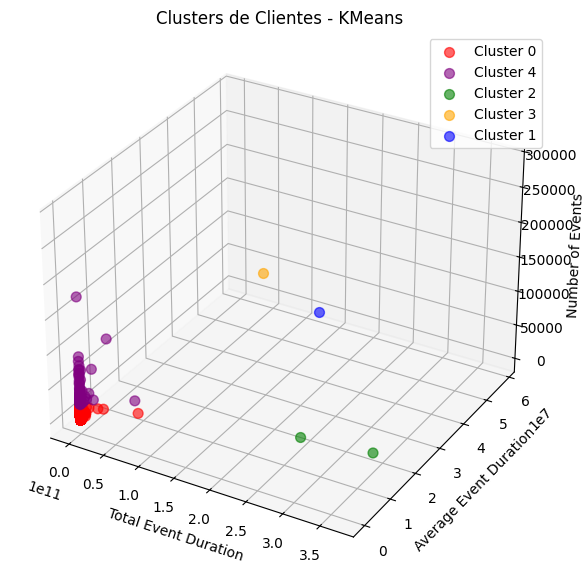

In [13]:
# Configura o plot 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Cores para cada cluster
cores = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']

# Plot de cada cluster
for cluster_id in df_clientes['cluster'].unique():
    cluster_df = df_clientes[df_clientes['cluster'] == cluster_id]
    ax.scatter(
        cluster_df['total_event_duration'],
        cluster_df['avg_event_duration'],
        cluster_df['num_events'],
        label=f'Cluster {cluster_id}',
        color=cores[cluster_id % len(cores)],
        s=50, alpha=0.6
    )

# Labels e título
ax.set_xlabel('Total Event Duration')
ax.set_ylabel('Average Event Duration')
ax.set_zlabel('Number of Events')
ax.set_title('Clusters de Clientes - KMeans')
ax.legend()
plt.show()


### **Clusters Dataset Definition and Loading:**

In [14]:
blob_clients = "tratado_dados_clientes.csv"
blob_clients_list = blob_service_client.get_blob_client(CONTAINER_NAME, BLOB_NAME)
stream = blob_clients_list.download_blob()
df_info_clientes = pd.read_csv(stream)

In [15]:
df_info_clientes.head()

,CLIENTE_ID,EVENT_DURATION,MODULO_ID,PRODUCT_LINE_ID,REFERENCE_DATE_START,SLOT_ID,STATUS_LICENCA,TCLOUD,CLIENTE_PRIME
0,T4308700,436064.0,523,3,2025-03-19,4001,Desconectado,NaN,NaN
1,T4308700,850705.0,534,3,2025-03-19,4001,Desconectado,NaN,NaN
2,T4308700,440917.0,534,3,2025-03-19,4001,Desconectado,NaN,NaN
3,T4308700,436063.0,523,3,2025-03-19,4001,Desconectado,NaN,NaN
4,T4308700,430097.0,534,3,2025-03-19,4001,Desconectado,NaN,NaN


In [16]:
telemetry_clients_clusters = pd.merge(
    df_info_clientes, 
    df_clientes, 
    on="CLIENTE_ID", 
    how="inner"
)

telemetry_clients_clusters.head()

,CLIENTE_ID,EVENT_DURATION,MODULO_ID,PRODUCT_LINE_ID,REFERENCE_DATE_START,SLOT_ID,STATUS_LICENCA,TCLOUD,CLIENTE_PRIME,total_event_duration,avg_event_duration,num_events,cluster
0,T4308700,436064.0,523,3,2025-03-19,4001,Desconectado,NaN,NaN,4.951026e+08,5368.65407,92221.0,4
1,T4308700,850705.0,534,3,2025-03-19,4001,Desconectado,NaN,NaN,4.951026e+08,5368.65407,92221.0,4
2,T4308700,440917.0,534,3,2025-03-19,4001,Desconectado,NaN,NaN,4.951026e+08,5368.65407,92221.0,4
3,T4308700,436063.0,523,3,2025-03-19,4001,Desconectado,NaN,NaN,4.951026e+08,5368.65407,92221.0,4
4,T4308700,430097.0,534,3,2025-03-19,4001,Desconectado,NaN,NaN,4.951026e+08,5368.65407,92221.0,4


### Exportação para o container clusters.

A célula abaixo pode estar em formato raw para evitar risco de inserção no container novamente.

# **Analysis for Playbooks**

In [17]:
cluster_summary = df_clientes.groupby("cluster").agg(
    clientes=("CLIENTE_ID", "count"),
    total_event_duration=("total_event_duration", "mean"),
    avg_event_duration=("avg_event_duration", "mean"),
    num_events=("num_events", "mean")
).reset_index()

cluster_summary


,cluster,clientes,total_event_duration,avg_event_duration,num_events
0,0,4387,5.360858e+07,1.233825e+04,1667.721450
1,1,1,1.254527e+11,5.807997e+07,2160.000000
2,2,2,3.268387e+11,8.524709e+06,39826.000000
3,3,1,2.562142e+11,9.060324e+05,282787.000000
4,4,74,2.831599e+09,5.799897e+04,42729.202703


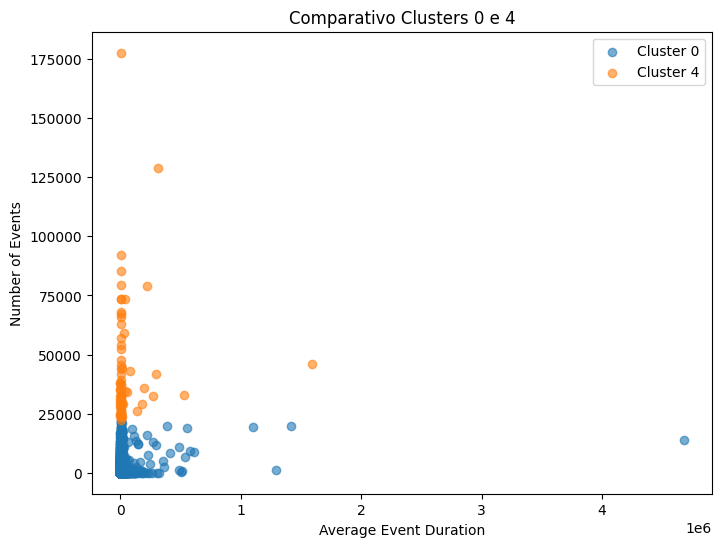

In [18]:
# Filtrar apenas os clusters 0 e 4
df_clusters_filtered = df_clientes[df_clientes["cluster"].isin([0, 4])]

# Plotar scatter plot
plt.figure(figsize=(8,6))
for cluster in [0, 4]:
    subset = df_clusters_filtered[df_clusters_filtered["cluster"] == cluster]
    plt.scatter(subset["avg_event_duration"], subset["num_events"], label=f"Cluster {cluster}", alpha=0.6)

plt.xlabel("Average Event Duration")
plt.ylabel("Number of Events")
plt.title("Comparativo Clusters 0 e 4")
plt.legend()
plt.show()


In [19]:
cluster_summary = df_clientes.groupby("cluster").agg(
    clientes=("CLIENTE_ID", "count"),
    total_event_duration=("total_event_duration", "mean"),
    avg_event_duration=("avg_event_duration", "mean"),
    num_events=("num_events", "mean")
).reset_index()

# Converter de ms para minutos
cluster_summary["total_event_duration_min"] = cluster_summary["total_event_duration"] / 60000
cluster_summary["avg_event_duration_min"] = cluster_summary["avg_event_duration"] / 60000

# Mostrar apenas colunas em minutos
cluster_summary[["cluster", "clientes", "total_event_duration_min", "avg_event_duration_min", "num_events"]]


,cluster,clientes,total_event_duration_min,avg_event_duration_min,num_events
0,0,4387,8.934763e+02,0.205637,1667.721450
1,1,1,2.090879e+06,967.999451,2160.000000
2,2,2,5.447312e+06,142.078476,39826.000000
3,3,1,4.270236e+06,15.100540,282787.000000
4,4,74,4.719332e+04,0.966649,42729.202703


In [20]:
df_clusters_filtered.cluster.value_counts()

cluster
0    4387
4      74
Name: count, dtype: int64

In [21]:
df_clusters_filtered[df_clusters_filtered["CLIENTE_ID"] == "T7527400"].head()["total_event_duration"]

4217    6.408457e+07
Name: total_event_duration, dtype: float64

### 🔎 **Análise dos clusters**

#### **Cluster 0 (4387 clientes)**

* **Maioria esmagadora dos clientes**.
* `avg_event_duration ≈ 12k` → eventos relativamente curtos.
* `num_events ≈ 1.6k` → uso moderado, volume de eventos bem menor que outros clusters.
* **Conclusão:** clientes "padrão", baixo a médio consumo, provavelmente a base do negócio.

---

#### **Cluster 4 (74 clientes)**

* Poucos clientes, mas:
* `avg_event_duration ≈ 58k` (5x maior que o cluster 0).
* `num_events ≈ 42k` (!!), muito maior que o cluster 0.
* **Conclusão:** heavy users, muito engajados, uso intenso da plataforma.

---

#### **Cluster 1 (1 cliente isolado)**

* Duração média **muito alta** (`58M`), mas só `2160 eventos`.
* Parece **outlier** (uso anômalo, um caso extremo).

---

#### **Cluster 2 (2 clientes)**

* `num_events ≈ 40k` mas duração média `≈ 8.5M`.
* Também outliers, com comportamento atípico de eventos **extremamente longos**.

---

#### **Cluster 3 (1 cliente isolado)**

* `num_events ≈ 280k`, mas duração média "baixa" (`≈ 900k` comparado aos outros outliers).
* Outro **outlier único**.

---

### 📌 Conclusões gerais

* **Cluster 0:** representa **a massa normal de clientes**, baixa/média intensidade.
* **Cluster 4:** representa um grupo **pequeno mas valioso**, heavy users.
* **Clusters 1, 2 e 3:** são **outliers** (clientes específicos com padrões bizarros).
  → Esses podem ser investigados individualmente, porque distorcem a média e provavelmente não vale tratar como grupo.

---

### 🛠️ Recomendações (Playbooks)

#### **Para o Cluster 0 (base de clientes)**

* **Onboarding & Educação:**
  Criar tutoriais, materiais e incentivos para aumentar o engajamento.
* **Campanhas de upsell:**
  Oferecer funcionalidades premium ou planos que aumentem o consumo.
* **Monitoramento de churn:**
  Como são clientes de baixo uso, estão mais propensos a churn → monitorar inatividade.

---

#### **Para o Cluster 4 (heavy users)**

* **Retenção VIP:**
  Criar programa especial de suporte/benefícios (ex: atendimento prioritário, descontos em upgrades).
* **Feedback contínuo:**
  Esses clientes são ideais para entrevistas, testes beta, coleta de sugestões.
* **Infraestrutura & Performance:**
  Garantir que o uso intenso deles não gere gargalos → talvez oferecer planos dedicados.
* **Monetização extra:**
  Avaliar precificação diferenciada (esses clientes provavelmente têm maior disposição a pagar).

---

👉 Resumindo:

* **Cluster 0 = massa (retenção + aumento de uso).**
* **Cluster 4 = heavy users (retenção premium + monetização).**
* **Clusters 1,2,3 = outliers (investigar e tratar separadamente).**
